# Voting in Virginia Starter Notebook

This is just a starter notebook with some "heatmap"/choropleth plots of Virginia and the 2020 election.

In [1]:
import geopandas as gpd
import mapclassify
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Load data
gdf = gpd.read_file('./va_admin_bndry/VirginiaCounty_ClippedToShoreline.shx') # Load Virginia shapefile for maps
vdf = pd.read_csv('./data/voting_VA.csv') # Load historical voting data
cdf = pd.read_csv('./data/county_adjacencies.csv') # Load county adjacency data and population data

# Merge shapefile data and county adjacency data:
gdf['FIPS_left'] = pd.to_numeric(gdf['STCOFIPS']) 
df = gdf.merge(cdf,left_on='FIPS_left',right_on='FIPS')  # merge county population and adjacency data into df
del gdf, cdf

# Population Data

Here is code to make choropleth maps:

<Axes: >

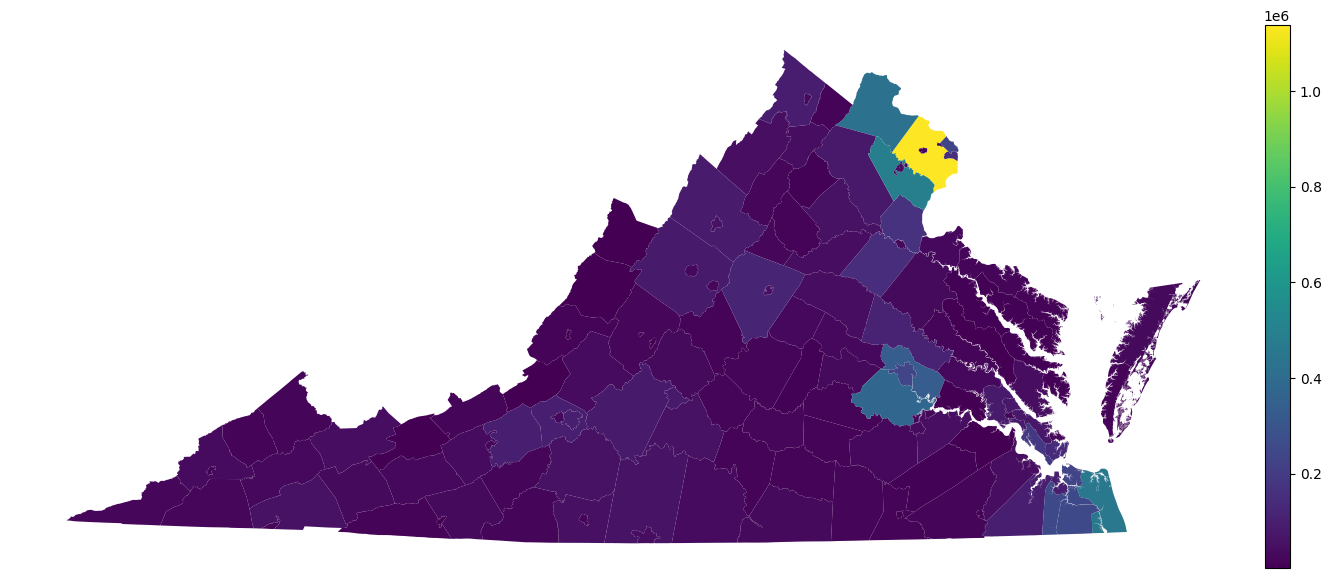

In [2]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='Population2022',legend=True,cax=cax)

# Voting Districts

My map:

<Axes: >

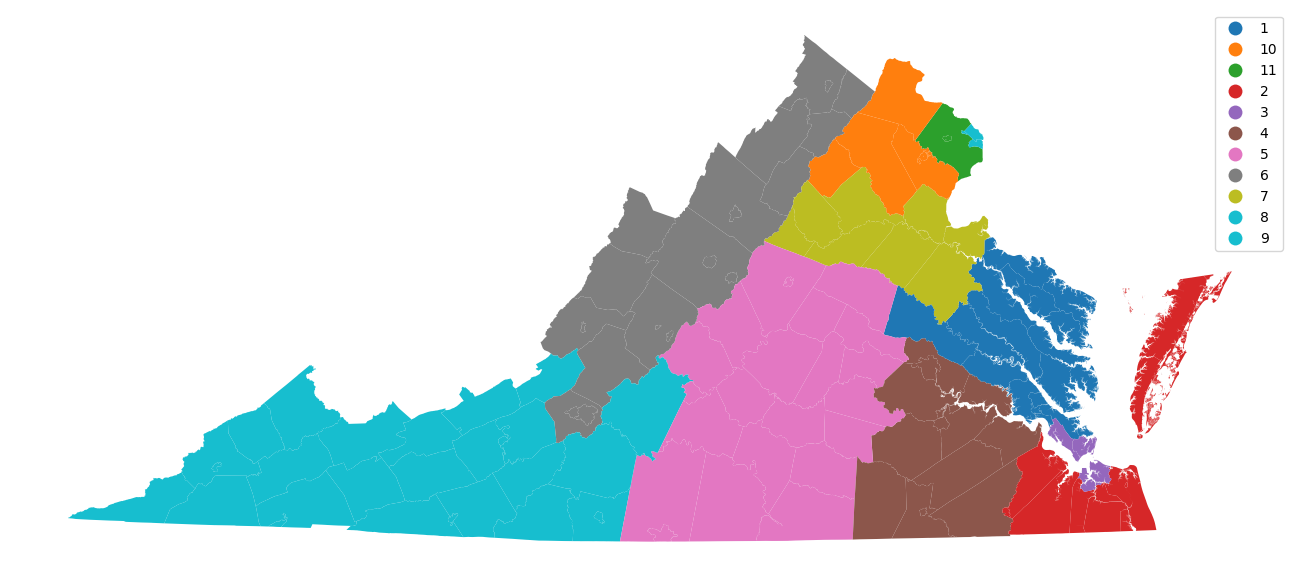

In [3]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
#cax = divider.append_axes("right", size="2%", pad=0.08)
df['Districts'] = df['District'].astype(str)
df.plot(ax=ax,column='Districts',legend=True)#,cax=cax

Actual map:

<img src="va_map.jpeg" width="1350" >

This is close but there are some issues to work out.

## Voting from 2020

Clean vote data and merge into the df we're using to make maps:

In [4]:
df20 = vdf.loc[ vdf['year']==2020,:] # Only the 2020 data

Dvotes = df20.loc[(df20['party']=='DEMOCRAT'),:].groupby('county_fips')['candidatevotes'].sum()
Dvotes = Dvotes.rename('dem_votes_2020')
df = df.merge(Dvotes,left_on='FIPS_left',right_on='county_fips') #df1.merge(df2, left_on='lkey', right_on='rkey

Rvotes = df20.loc[(df20['party']=='REPUBLICAN'),:].groupby('county_fips')['candidatevotes'].sum()
Rvotes = Rvotes.rename('rep_votes_2020')
df = df.merge(Rvotes,left_on='FIPS_left',right_on='county_fips') #df1.merge(df2, left_on='lkey', right_on='rkey

Raw 2020 Democrat votes:

<Axes: >

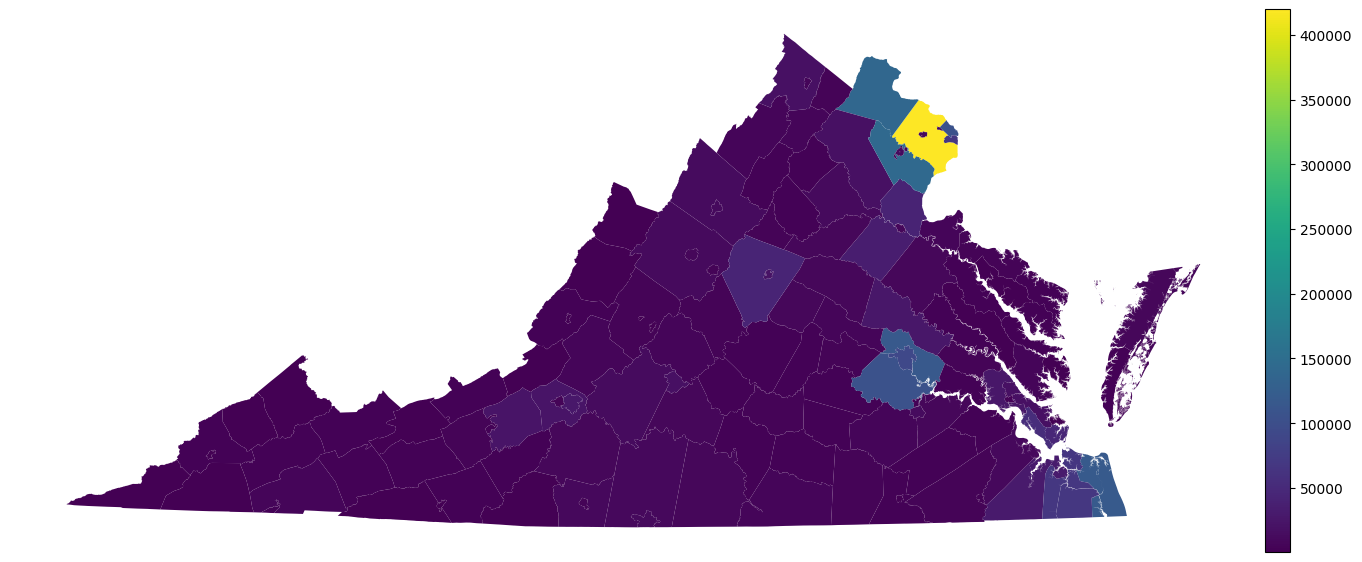

In [5]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='dem_votes_2020',legend=True,cax=cax)

Raw Republican votes:

<Axes: >

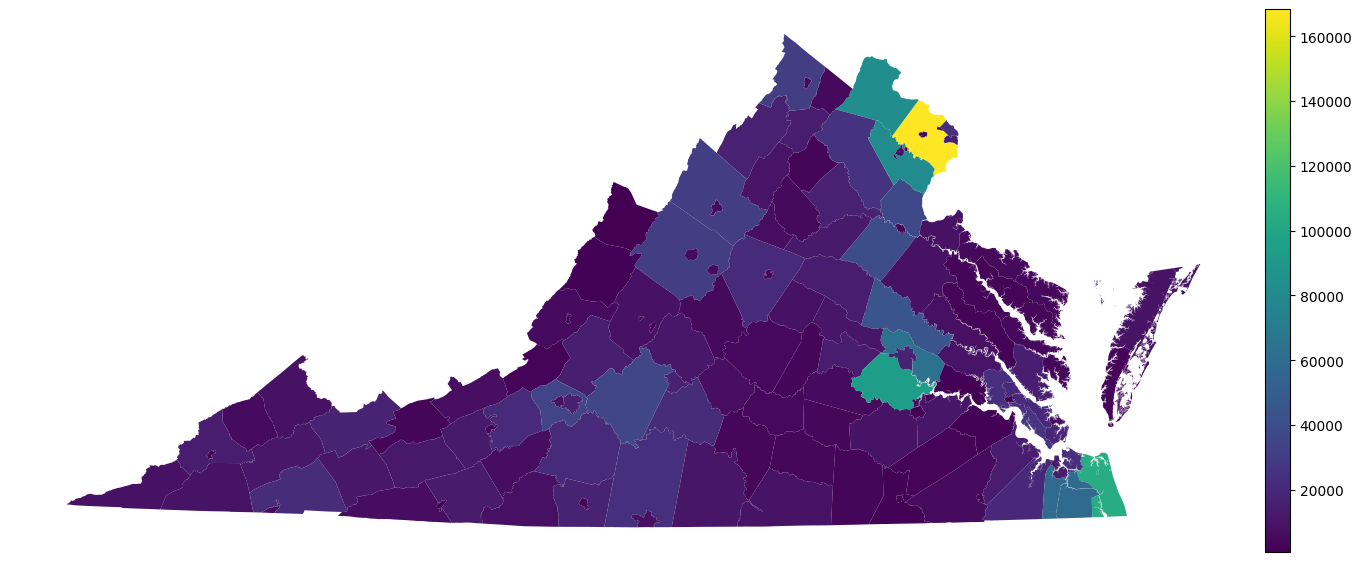

In [6]:
fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='rep_votes_2020',legend=True,cax=cax)

Since both more D's and R's live places where more people live, you get really similar maps. But if you look at the scales, they're very different. We need to represent not just the raw levels, but the vote margins between the two parties.

Difference in Dem and Rep votes:

<Axes: >

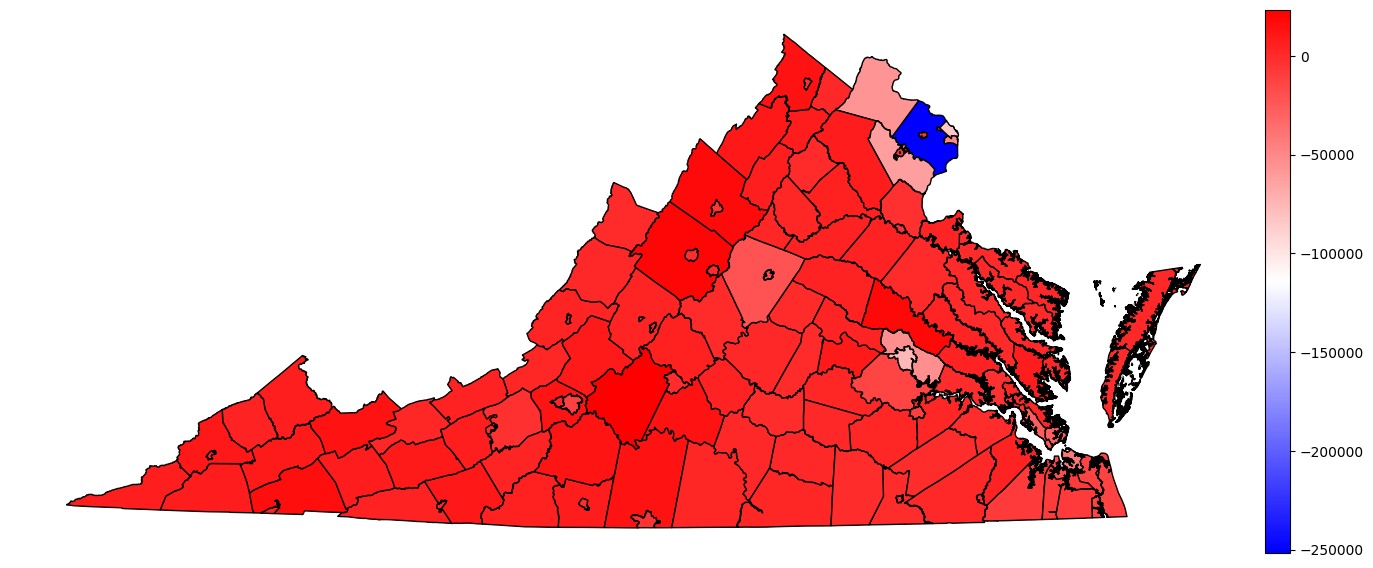

In [7]:
df['vote_diff'] = df['rep_votes_2020']-df['dem_votes_2020']

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff',legend=True,cax=cax,cmap='bwr',edgecolor='k')

That plot is somewhat misleading because the "white" color values don't correspond to zero, but rather -100,000, making the state look more red than it is. Because of the psychology of the visualization, it's probably better not to pick red/blue colors:

<Axes: >

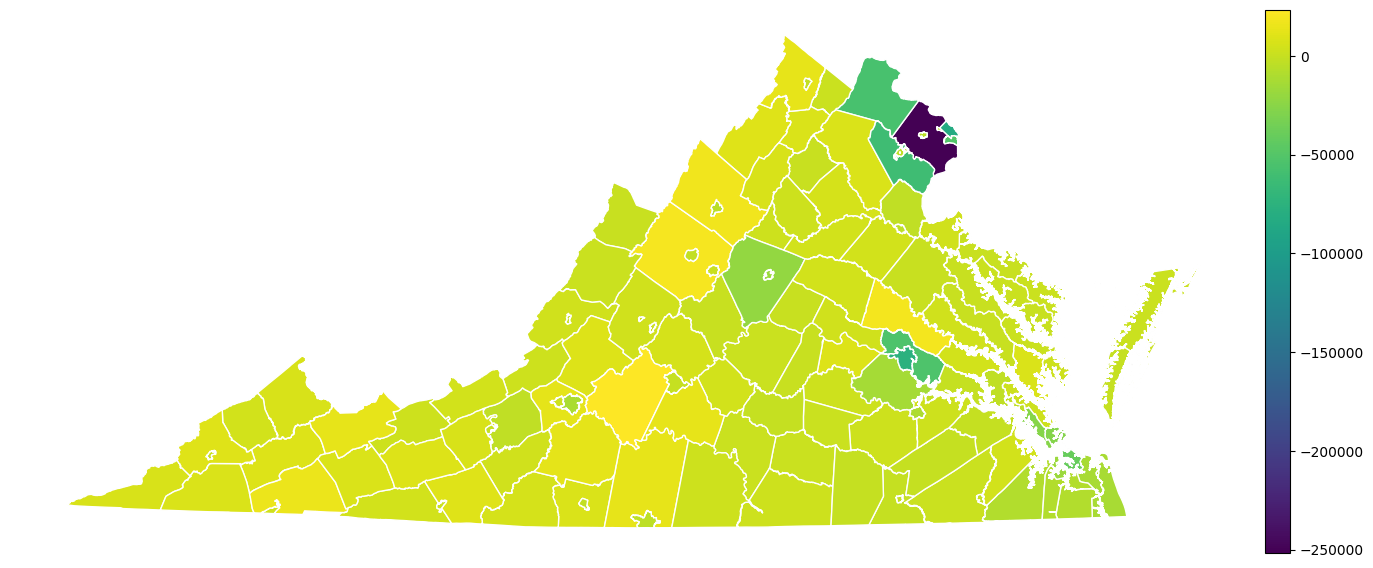

In [8]:
df['vote_diff'] = df['rep_votes_2020']-df['dem_votes_2020']

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff',legend=True,cax=cax,edgecolor='w')

Here's a way to discretize the scale:

<Axes: >

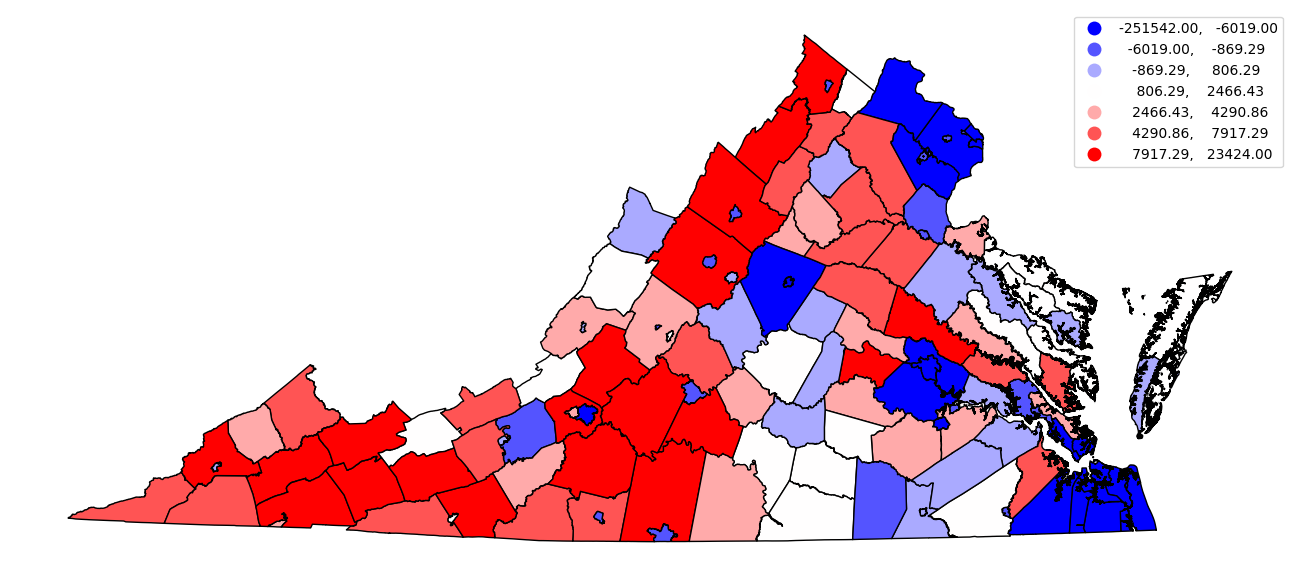

In [9]:
df['vote_diff'] = df['rep_votes_2020']-df['dem_votes_2020']

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
#cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff',legend=True,cmap='bwr',edgecolor='k',scheme='Quantiles',k=7)

Slightly better, still not perfect.

That is a very long tail. Support for the Democrats is extremely strong in the north-northeast and southeast parts of the state.

Let's take the inverse hyperbolic sine of the difference to resolve some of the "long tail" issues:

<Axes: >

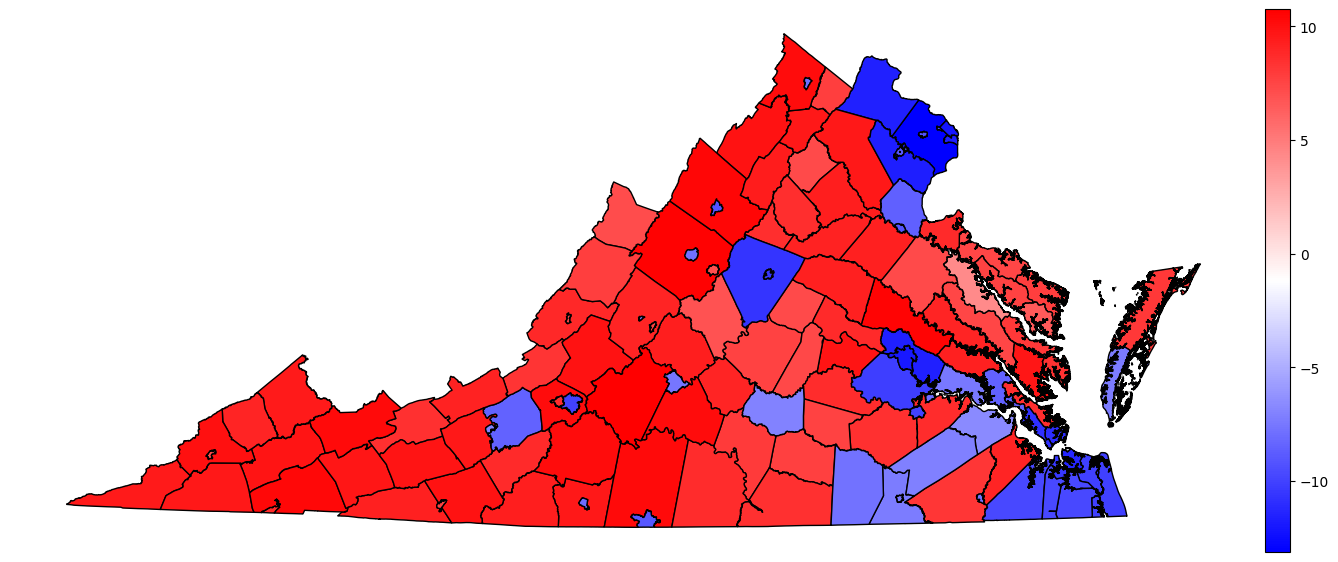

In [10]:
df['vote_diff_ihs'] = np.arcsinh(df['vote_diff'])

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='vote_diff_ihs',legend=True,cax=cax,cmap='bwr',edgecolor='k')

This is pretty good. This gives a little more information about where Democrat strongholds are, versus Republican strongholds, and the intensities are in "log votes" rather than percentages, so the picture is easier to interpret.

We could also compute the percent difference:
$$
\dfrac{Dem - Rep}{Rep}
$$


<Axes: >

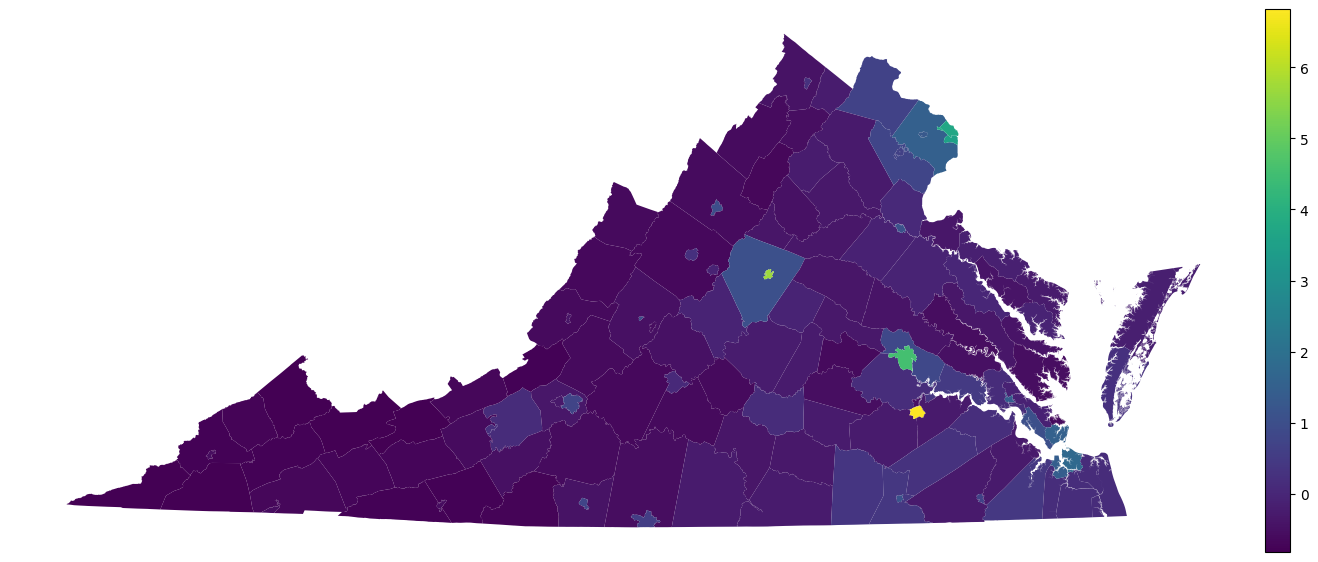

In [11]:
df['pct_diff'] = -df['vote_diff']/df['rep_votes_2020']

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='pct_diff',legend=True,cax=cax)

Can you see Charlottesville, Richmond, Fairfax, and Petersburg? The danger in looking at percent difference, though, is that a small place might overwhelmingly prefer one party, but they don't have enough votes to carry the election if they are merged with a nearby political unit that is much larger and more purple. That's why looking at the arcsinh of vote differences gives a pretty useful guide not just to the intensity of support in terms of local opinion, but the vote margin as well.

Notice that if we compute the percent difference in the opposite direction, the pictures seems to tell a slightly different story?

<Axes: >

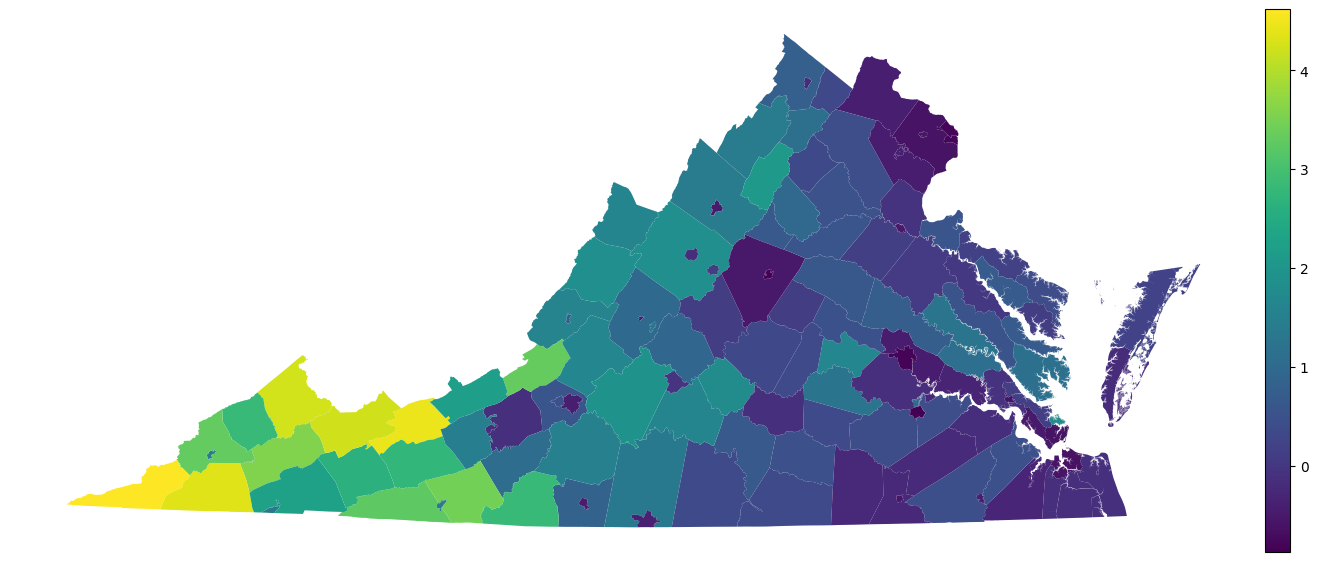

In [12]:
df['pct_diff'] = df['vote_diff']/df['dem_votes_2020']

fig = plt.figure()
ax = fig.add_axes([0, 0, 2, 2])
divider = make_axes_locatable(ax)
ax.axis('off')
cax = divider.append_axes("right", size="2%", pad=0.08)
df.plot(ax=ax,column='pct_diff',legend=True,cax=cax)

So these maps are fun, but you have to be careful to understand what you're looking at before jumping to conclusions.